In [1]:
import sys
sys.path.append('..')

In [2]:
# ckpt = '2501/COSEM_jrc-hela-UnetClassifier-l2/3/'
# ckpt = '2501/COSEM_jrc-hela-UnetClassifier-l2/6'
# ckpt = '2502/HT_LIF24-UnetClassifier-l2/3'
# ckpt = '/group/jug/ashesh/training/diffsplit/2502/BioSR-UnetClassifier-l2/4/'
ckpt = '/group/jug/ashesh/training/diffsplit/2502/HT_T24-UnetClassifier-l2/2'
evaluate_test_data = True
# num_timesteps_normalization = 100_000
# if normalize_channels is None, we use the setting (True/False) present in the trained model.
# if normalize_channels is True, then we normalize the channels in the dataset and xt_normalizer, defined below is dummy
# if normalize_channels is False, then we do not normalize the channels in the dataset and xt_normalizer, defined below normalizes the individual channels.
normalize_channels = None
assert normalize_channels in [None, True, False]
training_rootdir = '/group/jug/ashesh/training/diffsplit/'

In [3]:
import yaml
import os
import glob
import torch

def model_checkpoint_fpath(ckpt, fname=None):
    ckpt_dir = os.path.join(training_rootdir, ckpt, 'checkpoint')
    if fname is not None:
        return os.path.join(training_rootdir, ckpt, fname)
    else:
        list_of_files = glob.glob(ckpt_dir +'/*_gen.pth') # * means all if need specific format then *.csv
        latest_file = max(list_of_files, key=os.path.getctime)
        fname = latest_file
        return os.path.join(ckpt_dir,latest_file)

def model_checkpoint_fpath_prefix(ckpt, fname=None):
    fpath = model_checkpoint_fpath(ckpt, fname)
    suffix = '_gen.pth'
    assert fpath.endswith(suffix)
    return fpath[:-len(suffix)]

def load_config(ckpt):
    config_path = os.path.join(training_rootdir,ckpt,'wandb/latest-run/files/config.yaml')

    with open(config_path) as stream:
        try:
            opt = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    
    keys = ["name","phase","gpu_ids","path","datasets","model","train"]
    return {k: opt[k]['value'] for k in keys}

In [4]:
from model.ddpm_modules.time_predictor import TimePredictor
from time_prediction_training import get_datasets
import os

classifier_ckpt = os.path.join(training_rootdir, ckpt)

opt = load_config(classifier_ckpt)
# loading dataset.
if evaluate_test_data:
    if opt['datasets']['train']['name'] == 'Hagen':
        opt['datasets']['val']['datapath'] = {
        'ch0': '/group/jug/ashesh/data/diffsplit_hagen/test/test_actin-60x-noise2-highsnr.tif',
        'ch1': '/group/jug/ashesh/data/diffsplit_hagen/test/test_mito-60x-noise2-highsnr.tif'
        }
    elif opt['datasets']['train']['name'] in ['COSEM_jrc-hela', 'BioSR', 'HT_LIF24','HT_T24']:
        opt['datasets']['val']['datapath'] = opt['datasets']['val']['datapath'].replace('/val', '/test')
    else:
        raise NotImplementedError(f'{opt["datasets"]["train"]["name"]} not implemented')

if 'patch_size' not in opt['datasets']:
    opt['datasets']['patch_size']  = opt['datasets']['train']['patch_size']

if 'max_qval' not in opt['datasets']:
    opt['datasets']['max_qval']  = 0.98

if 'uncorrelated_channels' not in opt['datasets']['train']:
    opt['datasets']['train']['uncorrelated_channels']  = False

if normalize_channels is not None:
    print(f'Overriding normalize_channels with {normalize_channels}')
    opt['datasets']['normalize_channels'] = normalize_channels

In [5]:
model_opt = opt['model']
model_kwargs = {}
model_kwargs['scale_augmentation'] = model_opt.get('scale_augmentation', False)
    
if model_kwargs['scale_augmentation']:
    model_kwargs['scale_augmentation_delta'] = model_opt['scale_augmentation_delta']

model = TimePredictor(
    in_channel=model_opt['unet']['in_channel'],
    out_channel=model_opt['unet']['out_channel'],
    norm_groups=model_opt['unet']['norm_groups'],
    inner_channel=model_opt['unet']['inner_channel'],
    channel_mults=model_opt['unet']['channel_multiplier'],
    attn_res=model_opt['unet']['attn_res'],
    res_blocks=model_opt['unet']['res_blocks'],
    dropout=model_opt['unet']['dropout'],
    image_size=opt['datasets']['patch_size'],
    **model_kwargs
    )
model = model.cuda()
model.load_state_dict(torch.load(os.path.join(classifier_ckpt,'best_time_predictor.pth')), strict=True)

# data


TimePredictor


<All keys matched successfully>

In [6]:
train_set, val_set = get_datasets(opt, tiled_pred=False)

Loading data from /group/jug/ashesh/data/diffsplit_HT_T24/train/train.tif
Computing mean and std for normalization
[TimePredictorDataset] Data: 292x2x(1608, 1608) Patch:512 Random:1 Aug:True Q:1.0 UpperClip:0Uncor:False ChW:[1.0, 1.0]
Adding Gaussian noise with std factor:  0.05
Loading data from /group/jug/ashesh/data/diffsplit_HT_T24/test/test.tif
[TimePredictorDataset] Data: 36x2x(1608, 1608) Patch:512 Random:0 Aug:False Q:1.0 UpperClip:0Uncor:False ChW:[1.0, 1.0]


Random patching set to True


  1%|          | 96/10000 [00:51<1:29:05,  1.85it/s]


Random patching set to False


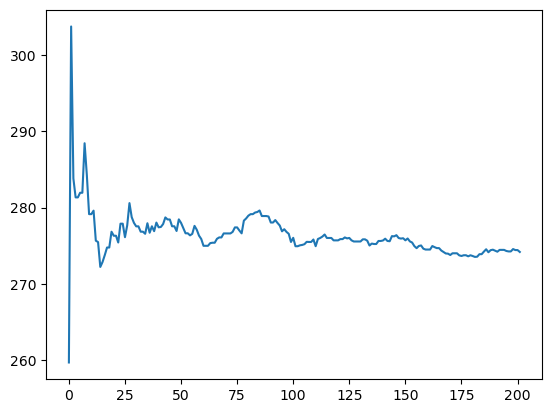

In [7]:
from model.normalizer import NormalizerXT
from tqdm import tqdm 
import numpy as np
import matplotlib.pyplot as plt
from time_prediction_training import get_normalizer

normalizer_count = None
# val_set.set_random_patching(True)
xt_normalizer = NormalizerXT()
if 'normalize_channels' in opt['datasets'] and opt['datasets']['normalize_channels'] is True:
    pass
else:
    if evaluate_test_data:
        xt_normalizer,data_mean_arr, data_std_arr = get_normalizer(val_set, opt, return_data_arr=True, num_pixels=500_000 * 128 * 128)
    else:
        xt_normalizer,data_mean_arr, data_std_arr = get_normalizer(train_set, opt, return_data_arr=True)
    # val_set.reset_fixed_t()
    # val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True, num_workers=0)
    # data_mean_arr = []
    # data_std_arr = []
    # normalizer_count = 100_000
    # cnt = 0
    # for _ in tqdm(range(normalizer_count)):
    #     bar = enumerate(val_loader)
    #     for i, (x, t_float) in bar:
    #         x = x.cuda()
    #         t_float = t_float.cuda()
    #         x = xt_normalizer.normalize(x,t_float, update=True)
    #         cnt += 1
    #         if cnt %10 == 0:
    #             data_mean_arr.append(xt_normalizer.data_mean.cpu().numpy())
    #             data_std_arr.append(xt_normalizer.data_std.cpu().numpy())

    plt.plot(np.stack(data_mean_arr)[:,90])
# val_set.set_random_patching(False)

In [8]:
del data_std_arr
del data_mean_arr
import gc; gc.collect()

3471

In [9]:
from tqdm import tqdm
import numpy as np

num_timesteps = 10
gt = np.arange(0,1.0,1/num_timesteps)
mmse_count = 1

pred_arr = []
inp_arr = []

with torch.no_grad():
    for mixing_t in tqdm(gt):
        val_set.set_fixed_t(mixing_t)
        dloader = torch.utils.data.DataLoader(
                    val_set,
                    batch_size=16,
                    shuffle=False,
                    num_workers=2,
                    pin_memory=True)
        for data in dloader:
            inp, t_float = data
            assert torch.std(t_float) < 1e-6, f'{t_float}'
            assert t_float[0] == mixing_t, f'{t_float} != {mixing_t}'
            inp = inp.cuda()
            t_float = t_float.cuda()
            # if xt_normalizer is dummy then nothing will happen with the following operation.
            inp = xt_normalizer.normalize(inp, t_float)
            inp_arr.append(inp.cpu().numpy())
            tmp_pred_arr = []
            for _ in range(mmse_count):
                with torch.no_grad():
                    pred = model(inp.cuda())
                    tmp_pred_arr.append(pred.cpu().numpy())
            pred_arr.append(np.median(np.stack(tmp_pred_arr),axis=0))
    
    all_pred = np.concatenate(pred_arr).reshape(len(gt),-1)
    inp_arr = np.concatenate(inp_arr,axis=0)


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:45<00:00,  4.54s/it]


In [10]:
print(np.mean(all_pred, axis=1))
print(np.median(all_pred, axis=1))

[0.13556579 0.1498796  0.24969268 0.3579579  0.45155594 0.5315321
 0.6056519  0.6864735  0.7727119  0.8613351 ]
[0.10508608 0.12118495 0.24097788 0.35102373 0.45191297 0.5329963
 0.6131903  0.6967735  0.7893499  0.88545454]


In [11]:
all_pred = np.concatenate(pred_arr).reshape(len(gt),-1)
inp_arr = np.concatenate(inp_arr,axis=0)


/tmp/ipykernel_4702/2798052624.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(gt,gt, 'k--', color='black')


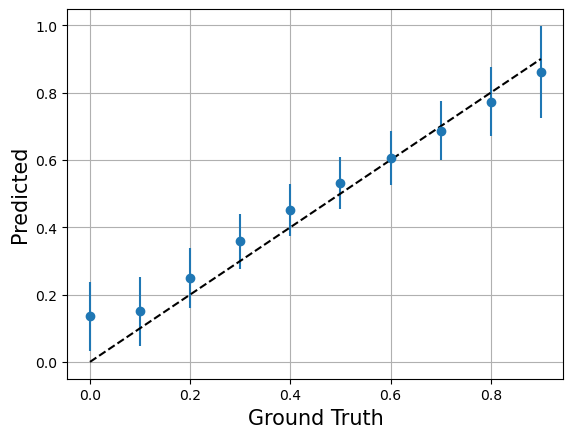

In [12]:
import matplotlib.pyplot as plt

err = all_pred.std(axis=1)
avg_pred = all_pred.mean(axis=1)
_,ax  = plt.subplots()
# plot with error bars
ax.errorbar(gt, avg_pred, yerr=err, fmt='o')
ax.plot(gt,gt, 'k--', color='black')
ax.set_xlabel('Ground Truth', fontsize=15)
ax.set_ylabel('Predicted', fontsize=15)
ax.grid()

In [13]:
mse = ((all_pred - gt.reshape(-1,1))**2).mean(axis=1)
dataset_str = opt['datasets']['train']['name']
dataset_str += ' Test' if evaluate_test_data else ' Val'
print(f'{dataset_str} NormCount:{normalizer_count} RMSE: {np.sqrt(mse.mean())}')

HT_T24 Test NormCount:None RMSE: 0.1109955133320669


In [14]:
mse_mean = ((np.mean(all_pred, axis=1) - gt)**2).mean()
mse_median = ((np.median(all_pred, axis=1) - gt)**2).mean()
print(f'{dataset_str} NormCount:{normalizer_count} RMSE wrt Aggregated (mean) prediction: {np.sqrt(mse_mean)}')
print(f'{dataset_str} NormCount:{normalizer_count} RMSE wrt Aggregated (median) prediction: {np.sqrt(mse_median)}')

HT_T24 Test NormCount:None RMSE wrt Aggregated (mean) prediction: 0.05727246616957797
HT_T24 Test NormCount:None RMSE wrt Aggregated (median) prediction: 0.04479686976003539
